# (논문) CAT/DOG
> CNN and CAM

- toc:true
- branch: master
- badges: true
- comments: true
- author: 김하영
- categories: [Study]

---

### import 

In [2]:
import torch 
from fastai.vision.all import *
import cv2

---

### data 

In [3]:
path=untar_data(URLs.PETS)/'images'

In [4]:
path

Path('/home/khy/.fastai/data/oxford-iiit-pet/images')

In [5]:
files=get_image_files(path)

In [6]:
def label_func(f):
    if f[0].isupper():
        return 'cat' 
    else: 
        return 'dog' 

In [7]:
dls=ImageDataLoaders.from_name_func(path,files,label_func,item_tfms=Resize(512)) 

Could not do one pass in your dataloader, there is something wrong in it


---

### learn

In [9]:
lrnr=cnn_learner(dls,resnet34,metrics=error_rate)
lrnr.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time


RuntimeError: CUDA out of memory. Tried to allocate 64.00 MiB (GPU 0; 23.70 GiB total capacity; 8.75 GiB already allocated; 37.06 MiB free; 8.87 GiB reserved in total by PyTorch)

---

### sample

#### 1st CNN and CAM

In [9]:
get_image_files(path)[0]

Path('/home/khy/.fastai/data/oxford-iiit-pet/images/boxer_128.jpg')

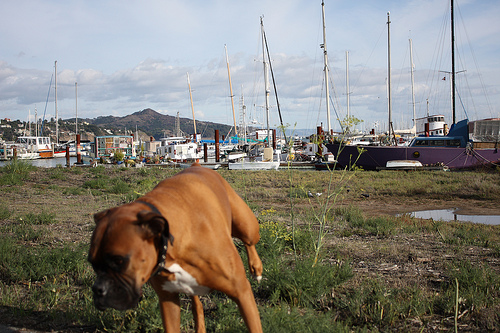

In [10]:
img = PILImage.create(get_image_files(path)[0])
img

In [11]:
x, = first(dls.test_dl([img]))  #이미지 텐서화

In [12]:
x.shape

torch.Size([1, 3, 512, 512])

In [13]:
net1=lrnr.model[0]
net2=lrnr.model[1] 

In [14]:
net2 = torch.nn.Sequential(
    torch.nn.AdaptiveAvgPool2d(output_size=1), 
    torch.nn.Flatten(),
    torch.nn.Linear(512,out_features=2,bias=False))

In [15]:
net=torch.nn.Sequential(net1,net2)

In [16]:
lrnr2=Learner(dls,net,metrics=accuracy) 

In [174]:
lrnr2.fine_tune(15) 

epoch,train_loss,valid_loss,accuracy,time
0,0.111267,0.533424,0.893775,00:39


epoch,train_loss,valid_loss,accuracy,time
0,0.061939,0.060303,0.975643,00:40
1,0.068718,0.093513,0.962788,00:40
2,0.046493,0.111640,0.968200,00:40
3,0.024927,0.056858,0.983085,00:40
4,0.014376,0.047533,0.984438,00:40


In [175]:
dls.vocab

['cat', 'dog']

- (고양이,강아지)라고 생각한 확률 

In [176]:
a=net(x).tolist()[0][0]
b=net(x).tolist()[0][1]
np.exp(a)/(np.exp(a)+np.exp(b)), np.exp(b)/(np.exp(a)+np.exp(b))

(0.00022025336829923823, 0.9997797466317008)

- CAM

In [177]:
camimg = torch.einsum('ij,jkl -> ikl', net2[2].weight, net1(x).squeeze())

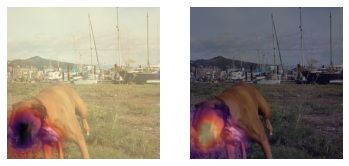

In [178]:
fig, (ax1,ax2) = plt.subplots(1,2) 
# 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(camimg[0].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(camimg[1].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')

---

#### 2nd CNN and CAM

- MODE 1 만들기

    - 가중치 재설정

In [219]:
test=camimg[1]-torch.min(camimg[1])

In [220]:
A1=torch.exp(-0.015*test)  

In [221]:
A2=1-A1

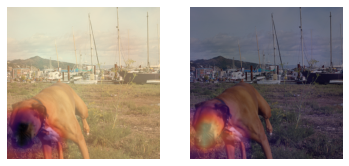

In [222]:
fig, (ax1,ax2) = plt.subplots(1,2) 
# 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(A1.data.to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(A2.data.to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')

In [223]:
A1.data.to('cpu').shape

torch.Size([16, 16])

In [224]:
X1=np.array(A1.to("cpu").detach(),dtype=np.float32)

In [225]:
Y1=torch.Tensor(cv2.resize(X1,(512,512),interpolation=cv2.INTER_LINEAR))

In [226]:
x1=x.squeeze().to('cpu')*Y1   #MODE1을 x1으로 저장

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<AxesSubplot:>

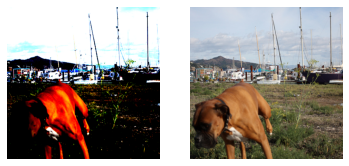

In [227]:
fig, (ax1,ax2) = plt.subplots(1,2) 
#
x1.show(ax=ax1)  #MODE1
dls.train.decode((x,))[0].squeeze().show(ax=ax2)

In [228]:
x1=x1.reshape(1,3,512,512)

In [229]:
net1.to('cpu')
net2.to('cpu')

Sequential(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=512, out_features=2, bias=False)
)

In [230]:
camimg1 = torch.einsum('ij,jkl -> ikl', net2[2].weight, net1(x1).squeeze())

In [232]:
camimg1.shape

torch.Size([2, 16, 16])

- CAM

    - mode1에 CAM 결과 올리기

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


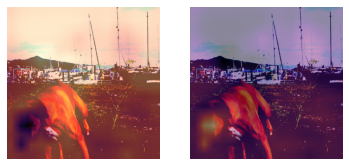

In [236]:
fig, (ax1,ax2) = plt.subplots(1,2) 
# 
x1.squeeze().show(ax=ax1)
ax1.imshow(camimg1[0].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
#
x1.squeeze().show(ax=ax2)
ax2.imshow(camimg1[1].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')

    - 첫번째 CAM결과와 비교

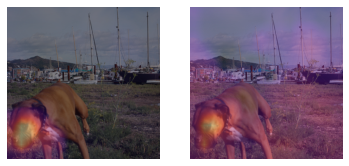

In [237]:
fig, (ax1,ax2) = plt.subplots(1,2) 
# 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(camimg[1].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(camimg1[1].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')

In [238]:
a1=net(x1).tolist()[0][0]
b1=net(x1).tolist()[0][1]
np.exp(a1)/(np.exp(a1)+np.exp(b1)), np.exp(b1)/(np.exp(a1)+np.exp(b1))

(0.08365200837651209, 0.9163479916234879)

---

## 3rd CNN

- MODE 2 만들기

In [243]:
test1=camimg1[1]-torch.min(camimg1[1])

In [265]:
A3=torch.exp(-0.03*test1)  

In [266]:
A4=1-A3

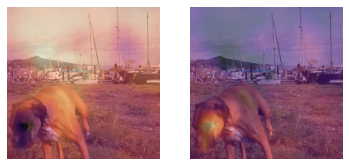

In [267]:
fig, (ax1,ax2) = plt.subplots(1,2) 
# 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(A3.data.to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(A4.data.to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')

In [268]:
A3.data.to('cpu').shape

torch.Size([16, 16])

In [269]:
X2=np.array(A3.to("cpu").detach(),dtype=np.float32)

In [270]:
Y2=torch.Tensor(cv2.resize(X2,(512,512),interpolation=cv2.INTER_LINEAR))

In [271]:
x2=x1.squeeze().to('cpu')*Y2   #MODE2을 x2로 저장

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<AxesSubplot:>

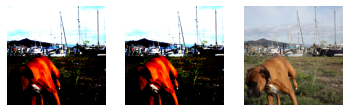

In [272]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3) 
#
x2.show(ax=ax1)  #MODE2
x1.squeeze().show(ax=ax2)  #MODE1
dls.train.decode((x,))[0].squeeze().show(ax=ax3)

In [273]:
x2=x2.reshape(1,3,512,512)

In [274]:
net1.to('cpu')
net2.to('cpu')

Sequential(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=512, out_features=2, bias=False)
)

In [275]:
camimg2 = torch.einsum('ij,jkl -> ikl', net2[2].weight, net1(x2).squeeze())

- CAM

    - mode2에 CAM 결과 올리기

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


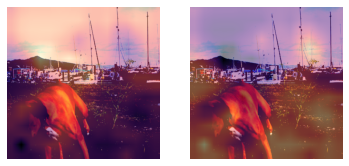

In [276]:
fig, (ax1, ax2) = plt.subplots(1,2) 
x2.squeeze().show(ax=ax1)
ax1.imshow(camimg2[0].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
x2.squeeze().show(ax=ax2)
ax2.imshow(camimg2[1].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')

    - 첫번째, 두번째 CAM결과와 비교

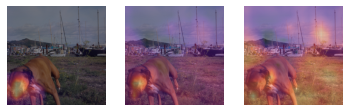

In [278]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3) 
# 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(camimg[1].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(camimg1[1].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
#
dls.train.decode((x,))[0].squeeze().show(ax=ax3)
ax3.imshow(camimg2[1].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')

In [279]:
a2=net(x2).tolist()[0][0]
b2=net(x2).tolist()[0][1]
np.exp(a2)/(np.exp(a2)+np.exp(b2)), np.exp(b2)/(np.exp(a2)+np.exp(b2))

(0.12893868865114902, 0.8710613113488509)

---

## 4th CNN

- MODE 3 만들기

In [280]:
test2=camimg2[1]-torch.min(camimg2[1])

In [298]:
A5=torch.exp(-0.05*test2)  

In [299]:
A6=1-A5

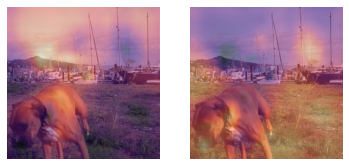

In [300]:
fig, (ax1,ax2) = plt.subplots(1,2) 
# 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(A5.data.to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(A6.data.to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')

In [301]:
A5.data.to('cpu').shape

torch.Size([16, 16])

In [302]:
X3=np.array(A5.to("cpu").detach(),dtype=np.float32)

In [303]:
Y3=torch.Tensor(cv2.resize(X3,(512,512),interpolation=cv2.INTER_LINEAR))

In [304]:
x3=x2.squeeze().to('cpu')*Y3   #MODE3을 x3로 저장

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<AxesSubplot:>

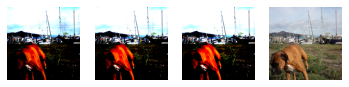

In [305]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4) 
#
x3.show(ax=ax1)  #MODE3
x2.squeeze().show(ax=ax2)  #MODE2
x1.squeeze().show(ax=ax3)  #MODE1
dls.train.decode((x,))[0].squeeze().show(ax=ax4)

In [306]:
x3=x3.reshape(1,3,512,512)

In [307]:
net1.to('cpu')
net2.to('cpu')

Sequential(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=512, out_features=2, bias=False)
)

In [308]:
camimg3 = torch.einsum('ij,jkl -> ikl', net2[2].weight, net1(x3).squeeze())

- CAM

    - mode3에 CAM 결과 올리기

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


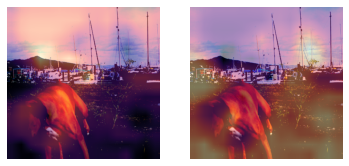

In [309]:
fig, (ax1, ax2) = plt.subplots(1,2) 
x3.squeeze().show(ax=ax1)
ax1.imshow(camimg3[0].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
x3.squeeze().show(ax=ax2)
ax2.imshow(camimg3[1].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')

    - 첫번째, 두번째, 세번째 CAM결과와 비교

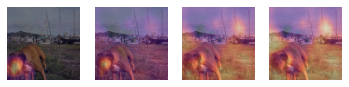

In [310]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4) 
# 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(camimg[1].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(camimg1[1].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
#
dls.train.decode((x,))[0].squeeze().show(ax=ax3)
ax3.imshow(camimg2[1].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
#
dls.train.decode((x,))[0].squeeze().show(ax=ax4)
ax4.imshow(camimg3[1].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')

In [311]:
a3=net(x3).tolist()[0][0]
b3=net(x3).tolist()[0][1]
np.exp(a3)/(np.exp(a3)+np.exp(b3)), np.exp(b3)/(np.exp(a3)+np.exp(b3))

(0.1645461226387444, 0.8354538773612555)